In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn import preprocessing
import os
import pickle

from ipywidgets import widgets
%matplotlib inline

In [2]:
# search for csv location

found = []

def find(name,path):
    path = os.getcwd() + path
    file = name

    for root, dir, files in os.walk(path):
        for item in files:
            if file == item:
                return os.path.join(root, file)
        return None
data = ['00', '01', '02', '03', '05', '22', '23', '24', '25']
#data = ['00', '01']

for d in data:
    found.append(find('data_' + d + '.csv.gz', '/irc-sphere-sleep-56db93f64661/sphere-sensor-data'))
    found.append(find('data_' + d + '.csv', '/irc-sphere-sleep-56db93f64661/sphere-sensor-data'))
found

['/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_00.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_01.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_02.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_03.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_05.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_22.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_23.csv.gz',
 None,
 '/Users/horken7/Documents/UoB/MDM3/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_24.csv.gz',
 None,


In [3]:
# load file

df = []
for path in found:
    if path is not None:
        if 'gz' in path:
            fileName = path
            df.append(pd.read_csv(fileName, index_col='datetime', compression='gzip'))
        else: 
            fileName = path
            df.append(pd.read_csv(fileName, index_col='datetime'))

//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def getFeatures(df):

    # arm angle calculation using accelerometer data
    df['angle'] = 180 / np.pi * np.arctan(df['wearable-xl1-z'] / np.sqrt(np.square(df['wearable-xl1-x']) + np.square(df['wearable-xl1-z'])))

    # get only interesting columns
    df = df[['angle', 'wearable-mag-xl1']]

    # remove NaN values
    df = df.dropna()
    # convert index to DatetimeIndex
    df.index = pd.DatetimeIndex(df.index)


    # resample data within interval given in resampleInterval ('1S' = 1 second intervals)
    resampleInterval = '1S'
    minimum = df.resample(resampleInterval).min()
    maximum = df.resample(resampleInterval).max()
    mean = df.resample(resampleInterval).mean()
    std = df.resample(resampleInterval).std()
    summ = df.resample(resampleInterval).sum()
    skew = df.resample(resampleInterval).apply(lambda array : stats.skew(array))
    kurtosis = df.resample(resampleInterval).apply(lambda array: stats.kurtosis(array, fisher=True))

    # rename column labels in DataFrame
    minimum.rename(columns={'angle': 'angle min'}, inplace=True)
    minimum.rename(columns={'wearable-mag-xl1': 'magnitude min'}, inplace=True)
    
    maximum.rename(columns={'angle': 'angle max'}, inplace=True)
    maximum.rename(columns={'wearable-mag-xl1': 'magnitude max'}, inplace=True)
    
    mean.rename(columns={'angle': 'angle mean'}, inplace=True)
    mean.rename(columns={'wearable-mag-xl1': 'magnitude mean'}, inplace=True)
    
    std.rename(columns={'angle': 'angle std'}, inplace=True)
    std.rename(columns={'wearable-mag-xl1': 'magnutude std'}, inplace=True)
    
    summ.rename(columns={'angle': 'angle sum'}, inplace=True)
    summ.rename(columns={'wearable-mag-xl1': 'magnitude sum'}, inplace=True)
    
    skew.rename(columns={'angle': 'angle skew'}, inplace=True)
    skew.rename(columns={'wearable-mag-xl1': 'magnitude skew'}, inplace=True)
    
    kurtosis.rename(columns={'angle': 'angle kurtosis'}, inplace=True)
    kurtosis.rename(columns={'wearable-mag-xl1': 'magnitude kurtosis'}, inplace=True)
    
    # collect DataFrames
    features = [minimum, maximum, mean, std, summ, skew, kurtosis]
    features = pd.concat(features, axis=1)

    
    # for some weird reason new nans appear. 
    # need to drop them to have same shape on what to plot
    features = features.dropna()
    std = std.dropna()
    
    return [features, std, df]

In [5]:
# load features from data over all nights
allFeatures = []
allStd = []
for d in df:
    [feature, std, dataf] = getFeatures(d)
    allFeatures.append(feature)
    allStd.append(std)

In [6]:
# normalise the values between a 0 1 range
def norm(features):
    features_array = features.values #return a numpy array
    min_max_scalar = preprocessing.MinMaxScaler()
    normalise = min_max_scalar.fit_transform(features_array)
    normalised_features = pd.DataFrame(normalise)

    # rename index and columns
    normalised_features.columns = features.columns
    normalised_features.index = features.index

    features = normalised_features.copy(deep=True)
    return features

In [7]:
# put all data in same df
data = pd.concat(allFeatures, axis=0)

# normalise the data
data = norm(data)

In [8]:
normalisedFeatures = []
for feature in allFeatures:
    feat = norm(feature)
    normalisedFeatures.append(feat)

In [9]:
# save all data to pkl
pickle.dump(normalisedFeatures, open('allFeatures.pkl','wb'))
data.to_pickle('normalisedDays.pkl')

# Can start from here to load data

In [44]:
# load pickled data
data = pd.read_pickle('normalisedDays.pkl')
normalisedFeatures = pickle.load(open('allFeatures.pkl','rb'))

In [45]:
# cluster data
label = KMeans(n_clusters=5, random_state=10).fit_predict(data)

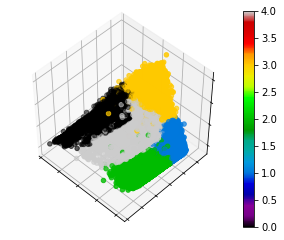

In [47]:
# plot PCA of clusters
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(data)
X = pca.transform(data)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

pca_plot = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label, cmap=plt.cm.spectral) # alt. cmap='spring'

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
fig.colorbar(pca_plot, ax=ax)
plt.savefig('allNight', dpi=500)
plt.show()

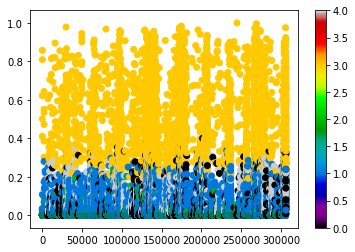

In [48]:
# scatter of labelled data (time index instead of timestamp to collect between days)
dots = pd.DataFrame(data['angle std'].values)

plt.scatter(dots.index, dots.values, c=label, cmap=plt.cm.spectral)
plt.colorbar()
plt.savefig('labeled', dpi=500)

# Train model and export features

In [14]:
# fit model to data
trainModel = KMeans(n_clusters=5, random_state=10).fit(data)

# this is the model that should be used to predict sleep/not

In [15]:
# merge clusters
def mergeCusters(label):
    label[label == 0] = 0
    label[label == 1] = 0
    label[label == 2] = 0
    label[label == 3] = 1
    label[label == 4] = 0
    return label

In [18]:
# collect features for the sleep data of each day
sleepFeatures = []
classifiedSleep = []

for i,feature in enumerate(normalisedFeatures):
    
    # produce new label for each day
    label = trainModel.predict(feature)
    
    # merge clusters into 2 clusters
    label = mergeCusters(label)
    
    # filter out awake data
    feature2 = feature.copy(deep=True)
    feature2['label'] = label
    sleep = feature2[feature2['label'] != 1]
    
    # get environment data (subset due to calculation time)
    d = df[i]
    environment = d[['light','noise','temperature']]
    
    # statistics calucaltion on given features
    feat = np.concatenate((sleep.mean(), sleep.std(), sleep.skew(), sleep.kurt(), environment.mean(), environment.std(), environment.skew(), environment.kurt()), axis=0)
    sleepFeatures.append(feat)
    classifiedSleep.append(feature2)
    
    

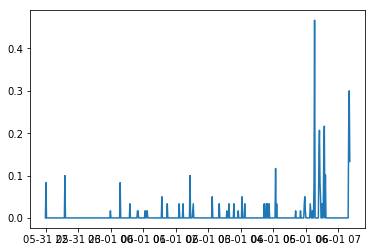

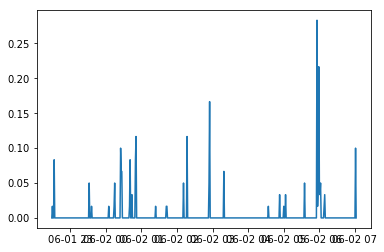

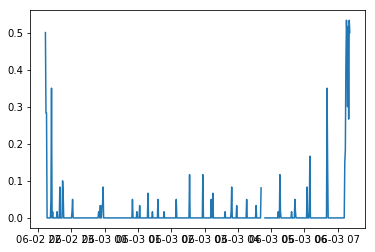

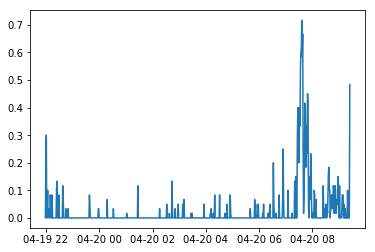

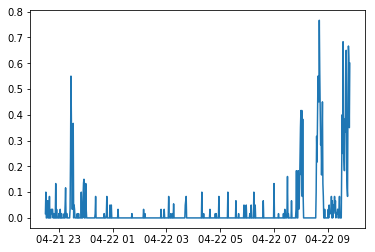

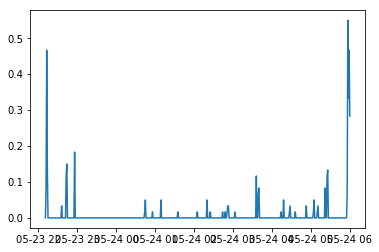

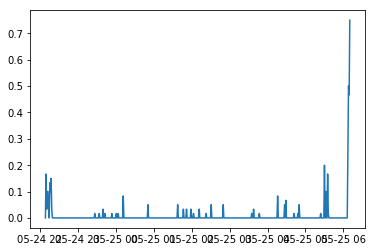

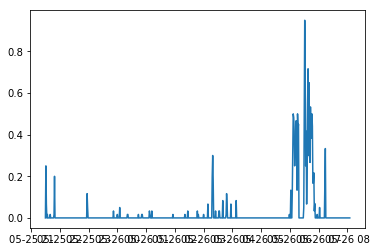

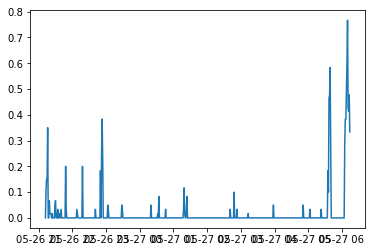

In [19]:
for i in range(len(normalisedFeatures)):
    # get sleep rounded sleep values per minute
    label = trainModel.predict(normalisedFeatures[i])
    label = mergeCusters(label)
    feature2 = normalisedFeatures[i].copy(deep=True)
    feature2['label'] = label
    feature2 = feature2.resample('1Min').mean()
    plt.figure(i)
    lbl, = plt.plot(feature2.index, feature2['label'])
    #plt.savefig('sleepStagesNight' + str(i+1), dpi=500)

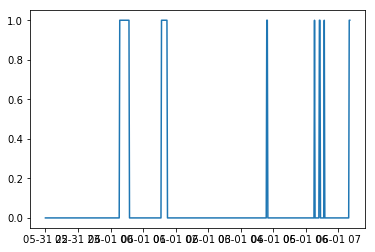

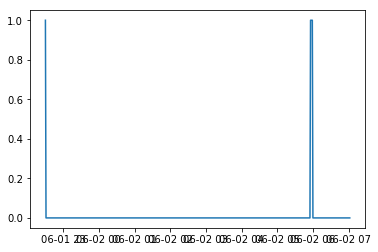

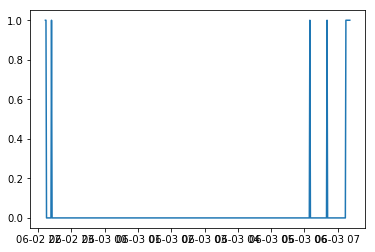

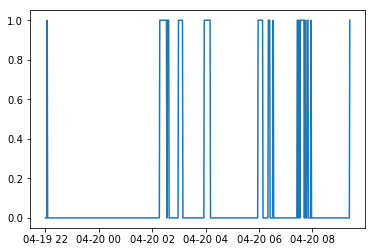

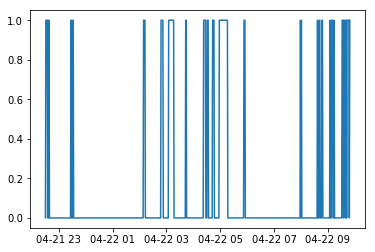

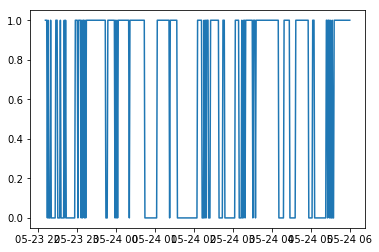

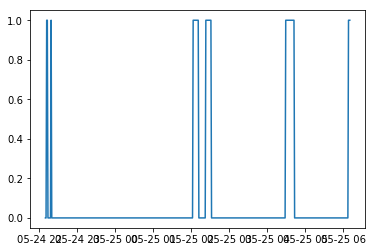

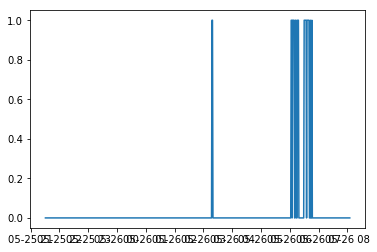

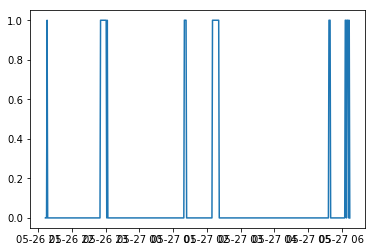

In [20]:
# print sleep in relation to environment
for i in range(len(normalisedFeatures)):
    # get sleep rounded sleep values per minute
    label = trainModel.predict(normalisedFeatures[i])
    #label = mergeCusters(label)
    feature2 = normalisedFeatures[i].copy(deep=True)
    feature2['label'] = label
    feature2 = feature2.resample('1Min').mean()

    # normalise data and plot against sleep
    df[i].index = pd.DatetimeIndex(df[i].index)
    dat = df[i].resample('1Min').mean()
    dat = dat.dropna()
    dat['label'] = feature2['label']
    dat = dat.dropna()
    dat = norm(dat)
    
    plt.figure(i)
    lbl, = plt.plot(dat.index, dat['label'].round())
    plt.savefig('classified'+str(i+1), dpi=500)

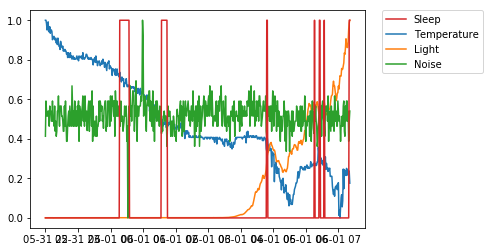

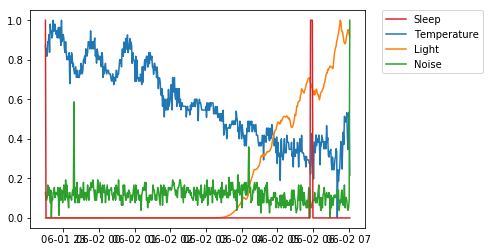

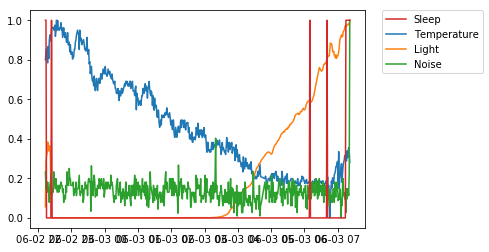

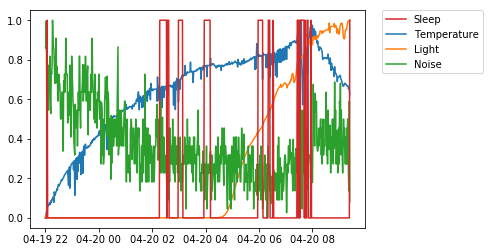

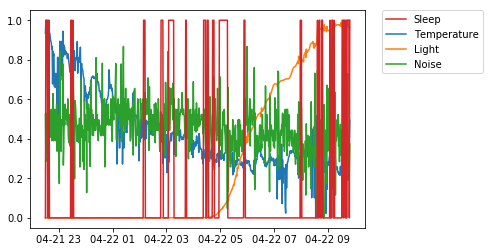

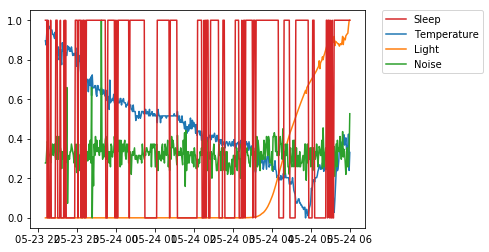

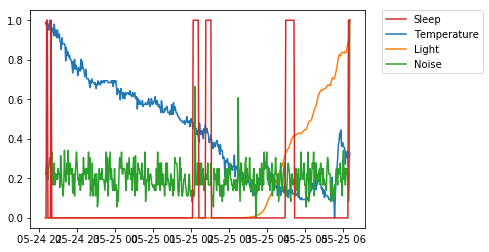

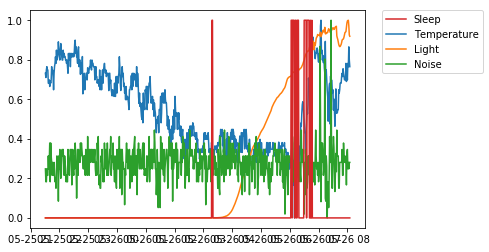

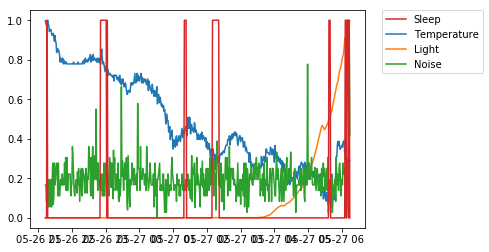

In [27]:
# print sleep in relation to environment
for i in range(len(normalisedFeatures)):
    # get sleep rounded sleep values per minute
    label = trainModel.predict(normalisedFeatures[i])
    #label = mergeCusters(label)
    feature2 = normalisedFeatures[i].copy(deep=True)
    feature2['label'] = label
    feature2 = feature2.resample('1Min').mean()

    # normalise data and plot against sleep
    df[i].index = pd.DatetimeIndex(df[i].index)
    dat = df[i].resample('1Min').mean()
    dat = dat.dropna()
    dat['label'] = feature2['label']
    dat = dat.dropna()
    dat = norm(dat)
    
    plt.figure(i)
    temp, = plt.plot(dat.index, dat['temperature'])
    light, = plt.plot(dat.index, dat['light'])
    noise, = plt.plot(dat.index, dat['noise'])
    lbl, = plt.plot(dat.index, dat['label'].round())
    lgd = plt.legend([lbl,temp,light,noise], ['Sleep','Temperature', 'Light', 'Noise'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('featuresSleep'+str(i+1), bbox_extra_artists=(lgd,), dpi=500)

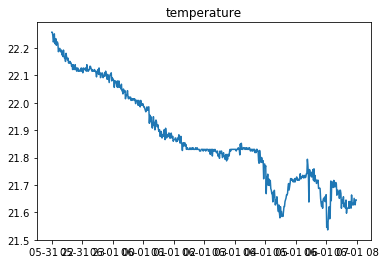

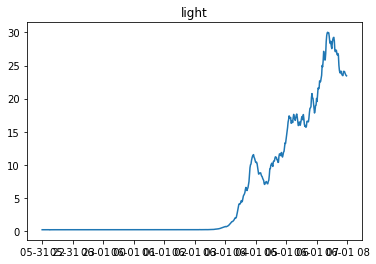

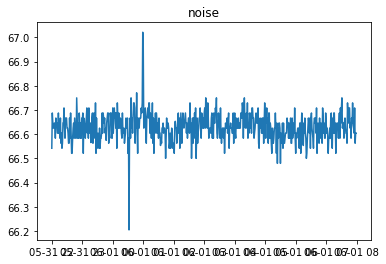

In [23]:
lbls = ['temperature', 'light', 'noise']

for i,n in enumerate(lbls):
    dta = []
    for d in df:
        d1 = df[0].resample('1Min').mean()
        d1.dropna()
        dta.append(d1[lbls])

feature = sum(dta) / len(dta)
blah = pd.DataFrame(feature)
blah.index = d1.index

for indx,lbl in enumerate(lbls):
    ind = []
    for i,n in enumerate(feature[lbl]):
        ind.append(i)

    plt.figure(indx)
    plt.title(lbl)
    plt.plot(blah.index, blah[lbl])
    plt.savefig(lbl, dpi=500)


//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


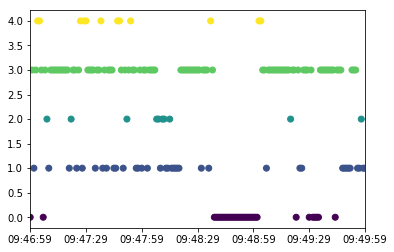

In [41]:
d = df[4]



[features, std, dd] = getFeatures(d[-5000:])

normFeat = norm(features)

label = trainModel.predict(normFeat)
#label = mergeCusters(label)



plt.scatter(normFeat.index, label, c=label)
plt.xlim(np.min(normFeat.index), np.max(normFeat.index))
plt.savefig('classified', dpi=500)

#plt.plot(d.index[-5000:], f[-5000:])
#plt.plot(d.index, d['wearable-mag-xl1'])

In [31]:
label

array([0, 3, 1, 3, 4, 4, 3, 0, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2,
       3, 3, 1, 3, 4, 1, 4, 4, 3, 3, 3, 3, 1, 3, 3, 4, 1, 3, 1, 3, 3, 3, 1,
       1, 4, 4, 3, 1, 3, 2, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 1, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 0, 3, 1, 1, 3, 3, 3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 1], dtype=int32)

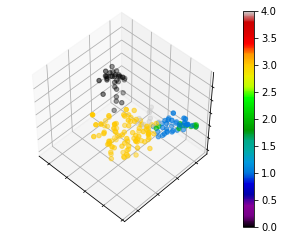

In [42]:
# plot PCA of clusters
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(normFeat)
X = pca.transform(normFeat)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

pca_plot = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label, cmap=plt.cm.spectral) # alt. cmap='spring'

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
fig.colorbar(pca_plot, ax=ax)
plt.savefig('awake', dpi=500)
plt.show()